##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 2.57
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 1, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result\\2.57"
numberOfGenerations = 150;
percolation = 0.49;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

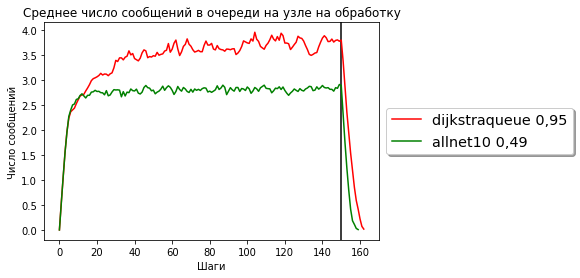

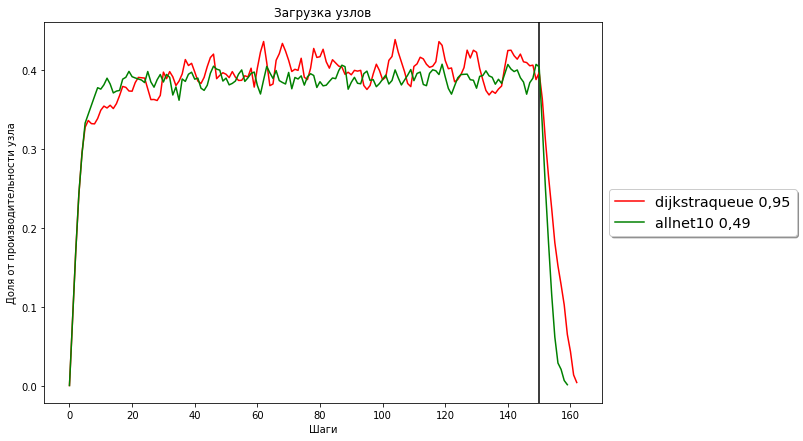

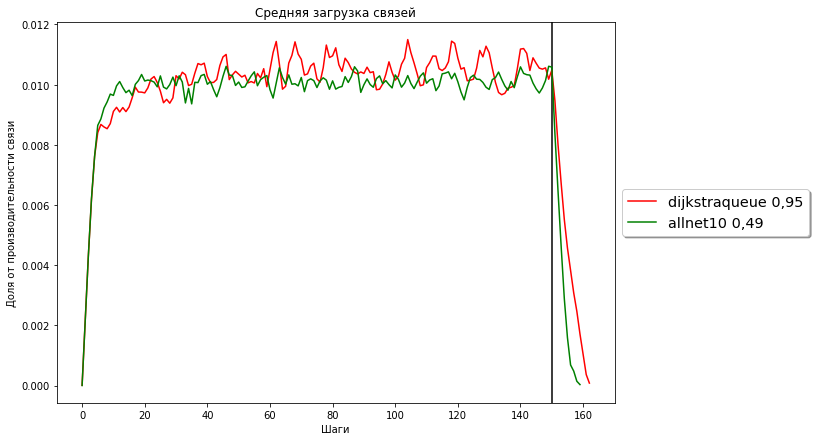

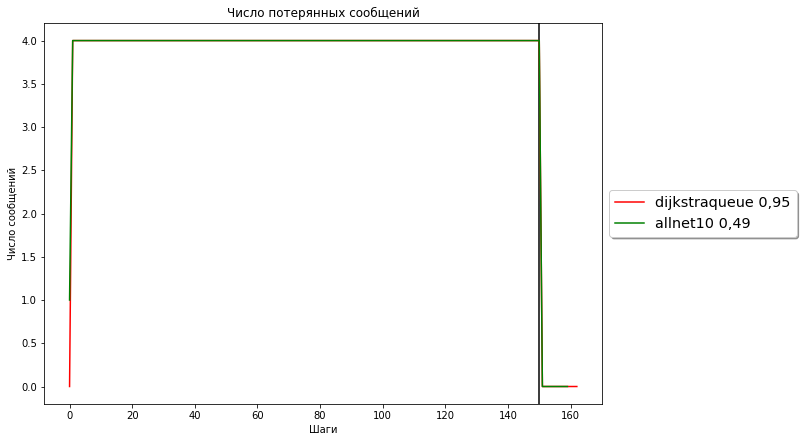

Доставлено 14401 Потеряно 3.9997% -dijkstraqueue 0,95
Доставлено 14400 Потеряно 4.0064% -allnet10 0,49


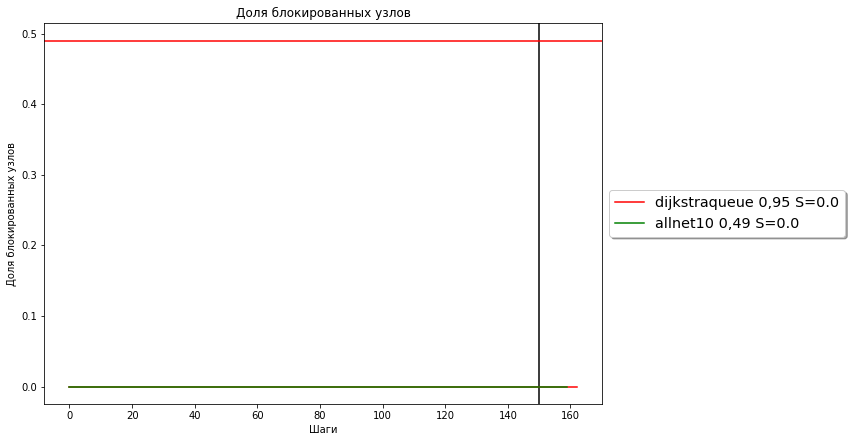

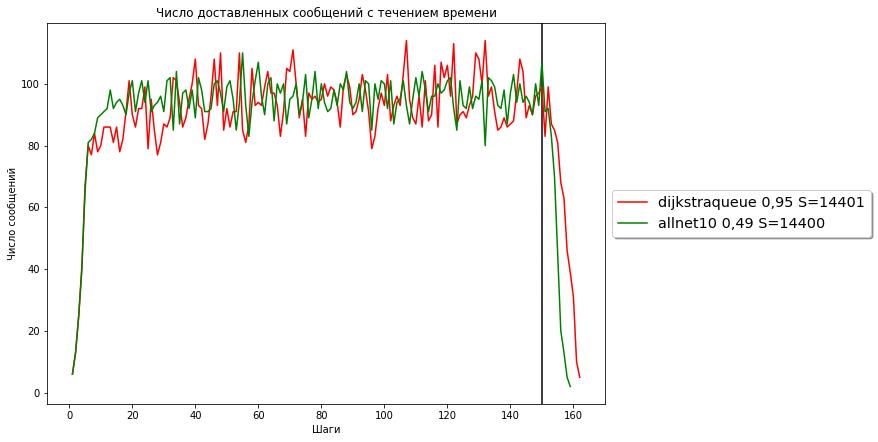

In [2]:
quantity = 100;
log_tags = [
{"tag":  "ceb9f965-9693-4c37-b17d-3db986b4c81d", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "25cb00a8-be7c-4014-b90f-b753e19269bf", "label": "allnet10 0,49", "color": "green"},
]
                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

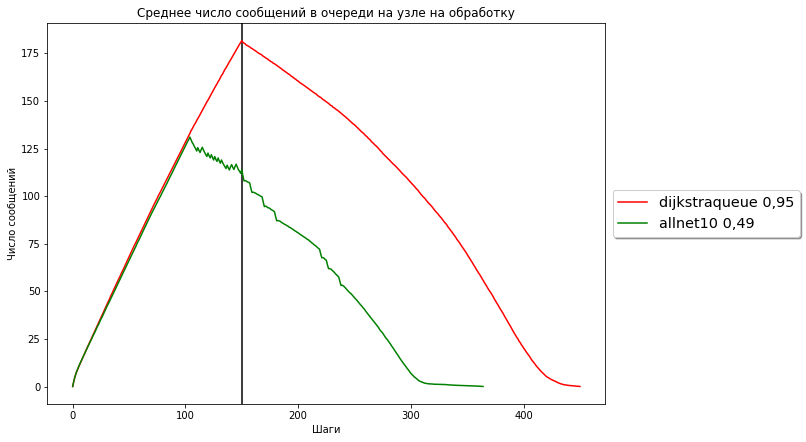

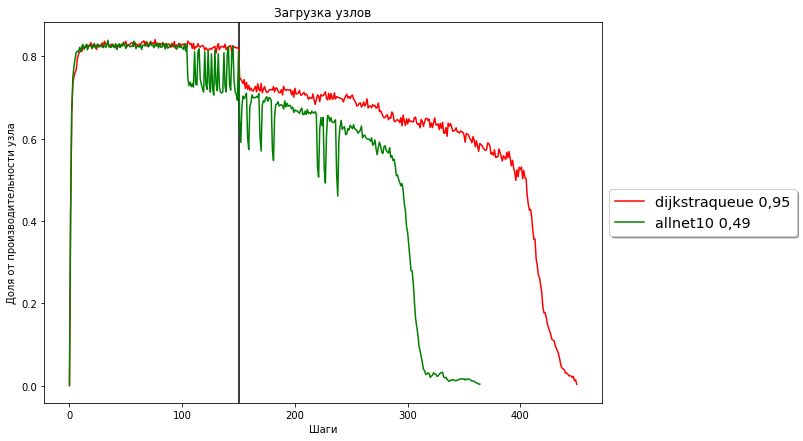

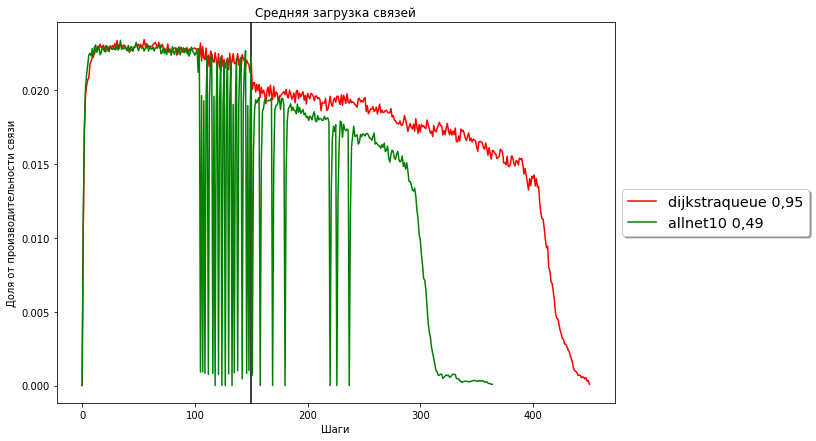

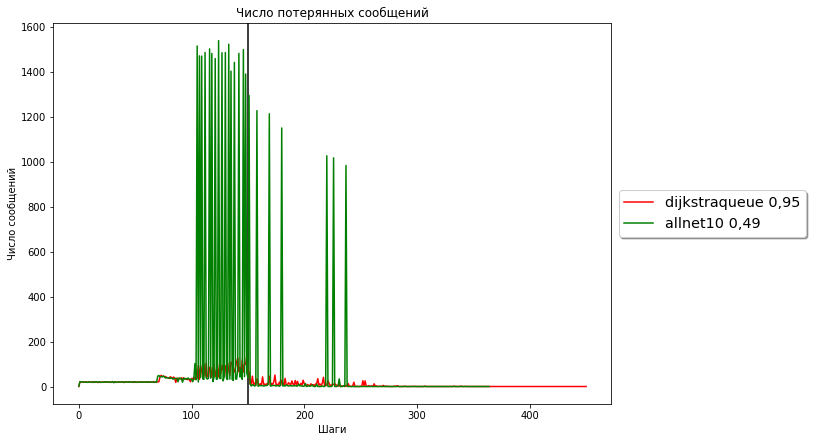

Доставлено 67497 Потеряно 10.0052% -dijkstraqueue 0,95
Доставлено 39335 Потеряно 47.5540% -allnet10 0,49


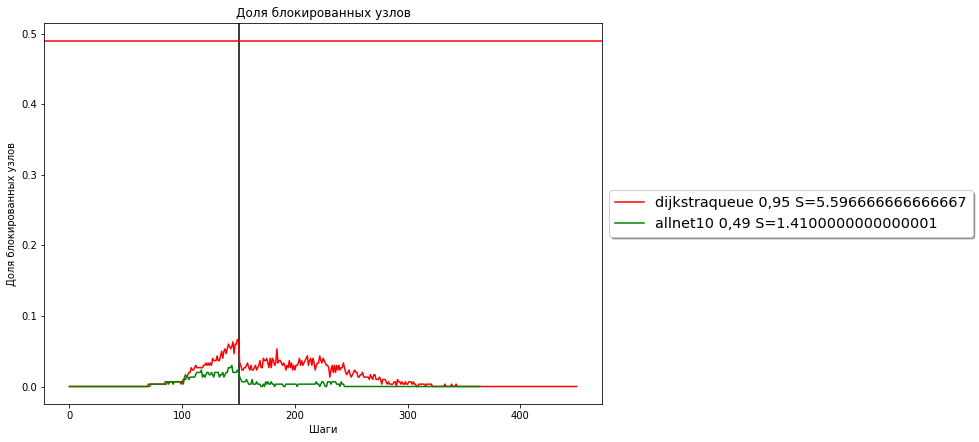

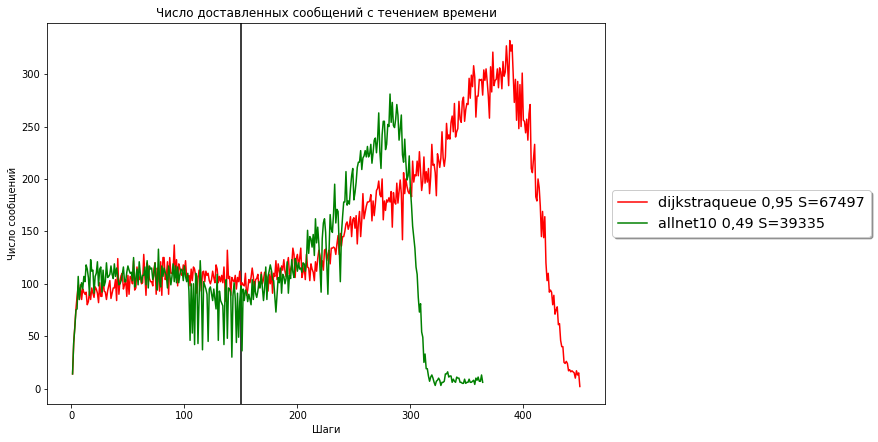

In [3]:
quantity = 500;
log_tags = [
{"tag":  "94008b6b-2c35-41b8-83a1-ea67e01bf1da", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "08719748-4c91-4dac-a835-a2e18149f2f9", "label": "allnet10 0,49", "color": "green"},
]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

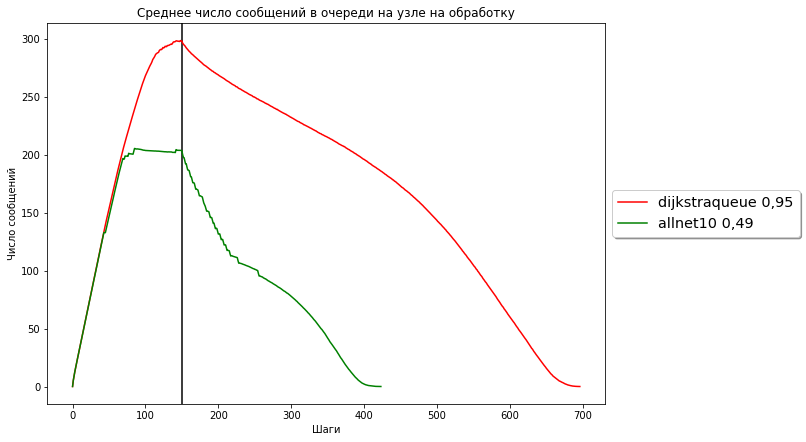

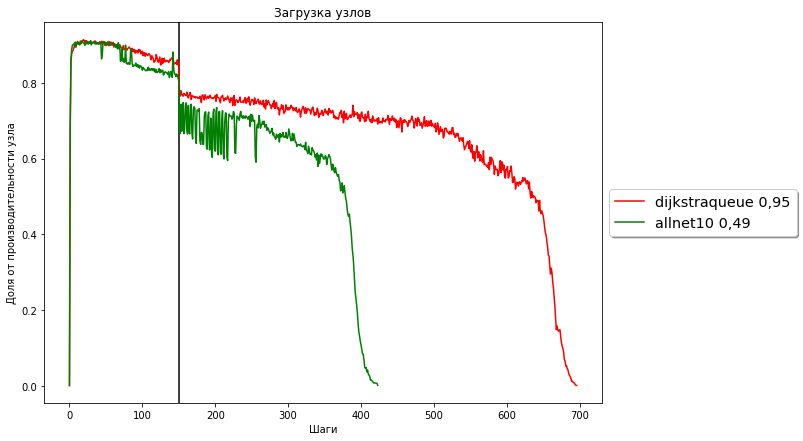

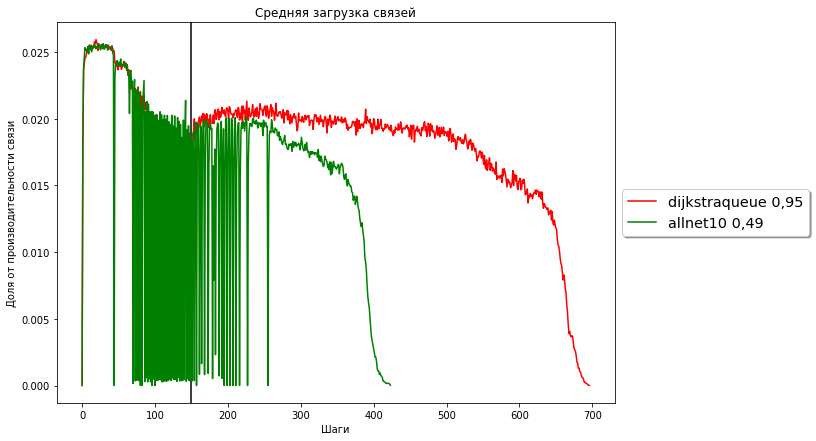

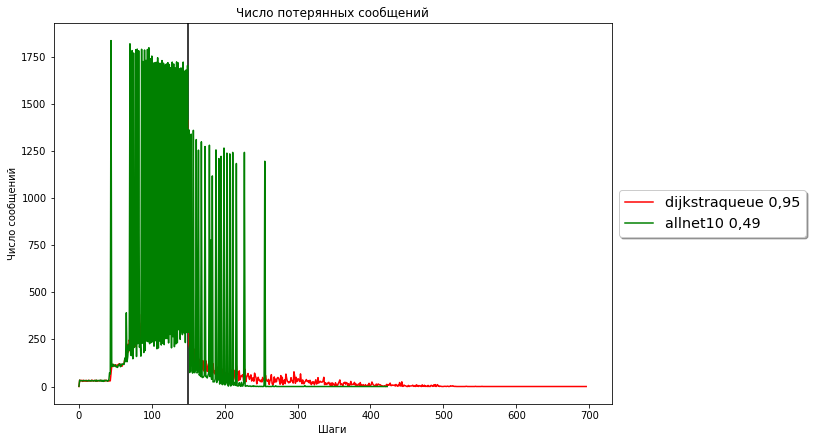

Доставлено 84960 Потеряно 43.3604% -dijkstraqueue 0,95
Доставлено 41000 Потеряно 72.6668% -allnet10 0,49


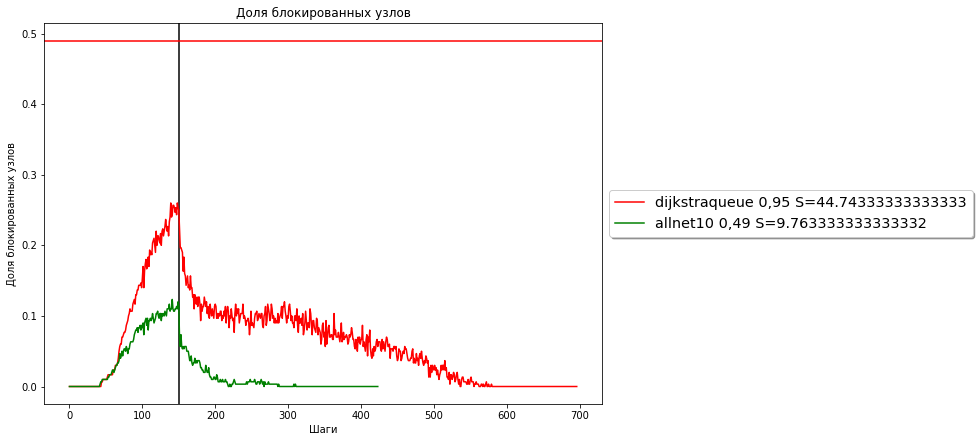

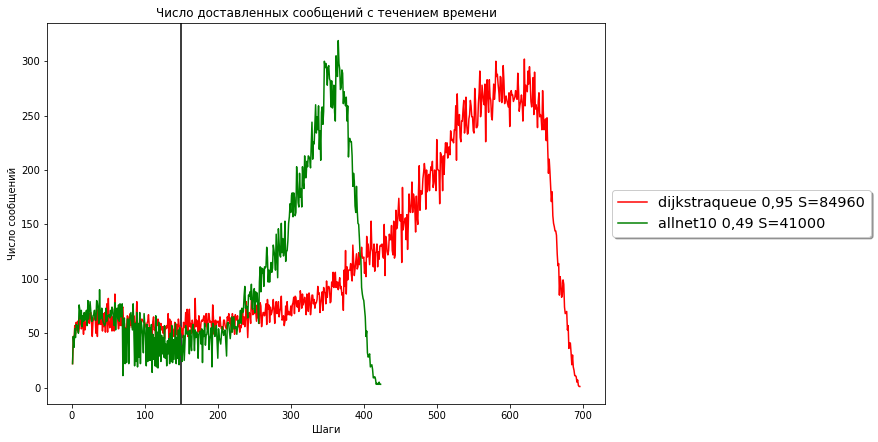

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "f8071bac-9c2d-4b08-a94f-9a43722956fb", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "197cc4e3-6d7b-42cd-9785-33ebae64f5ff", "label": "allnet10 0,49", "color": "green"},
]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

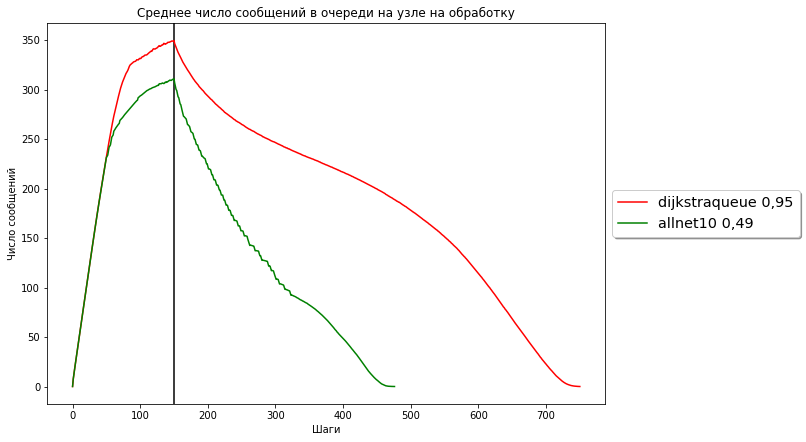

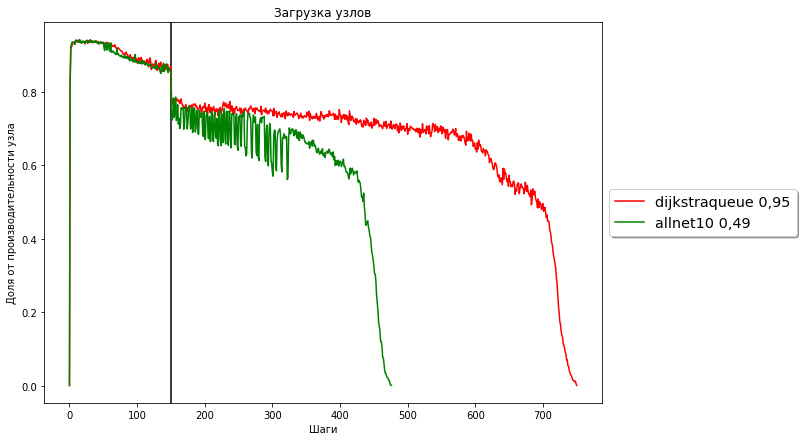

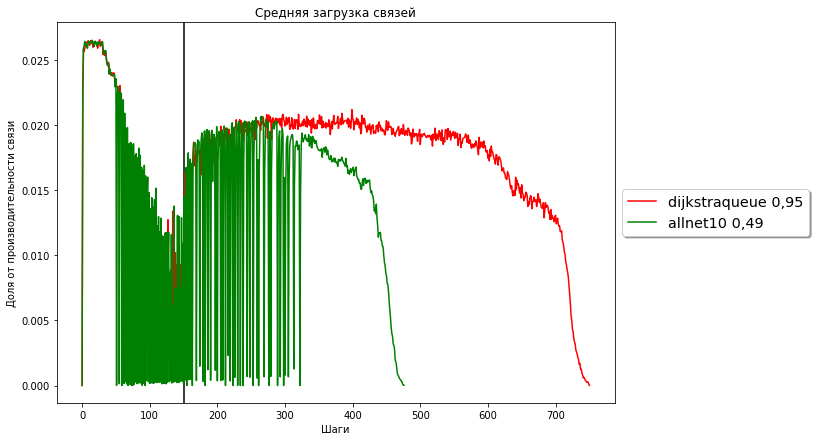

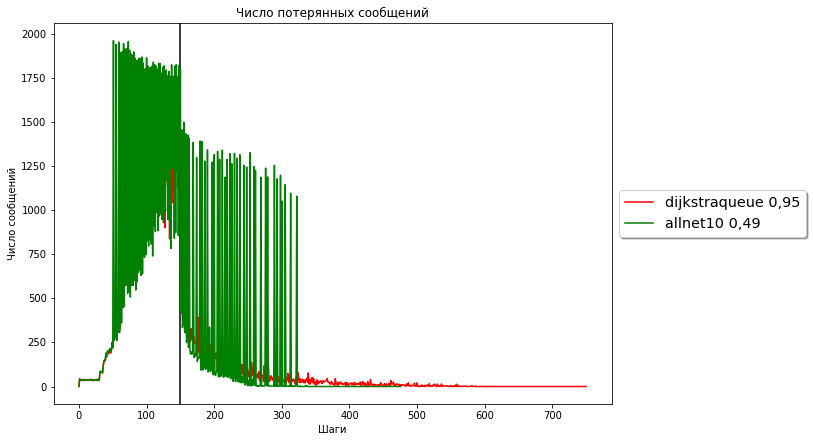

Доставлено 83349 Потеряно 62.9562% -dijkstraqueue 0,95
Доставлено 39193 Потеряно 82.5810% -allnet10 0,49


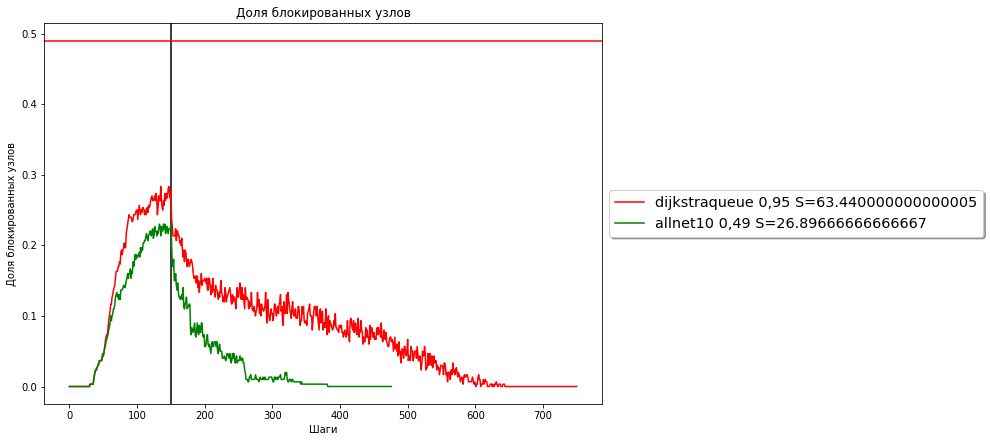

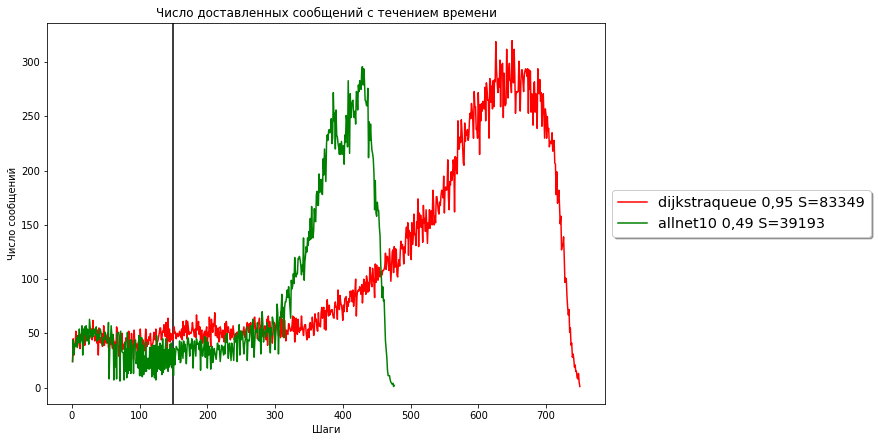

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "035c07ae-35a2-425f-ba38-362722282a34", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "6666f2d6-b76e-44fc-98d5-68ce4a0cacc4", "label": "allnet10 0,49", "color": "green"},
]
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 42979 Потеряно 4.4932% -dijkstraqueue 0,95
Доставлено 38344 Потеряно 14.7930% -allnet10 0,49


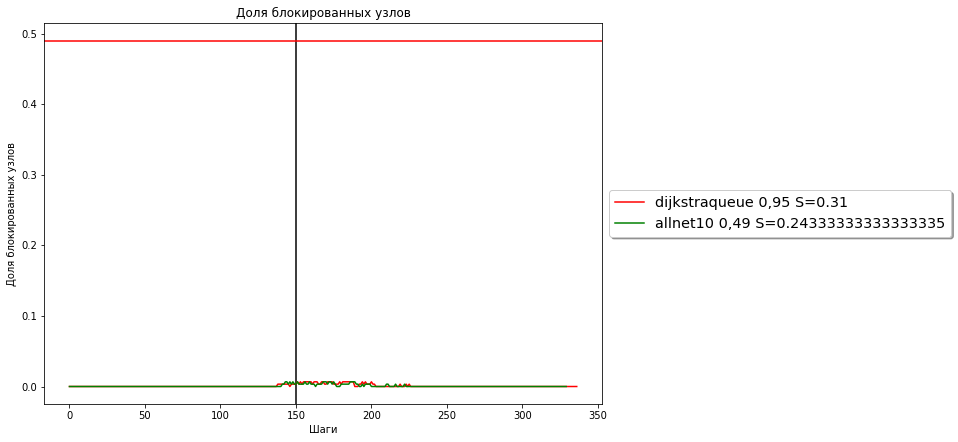

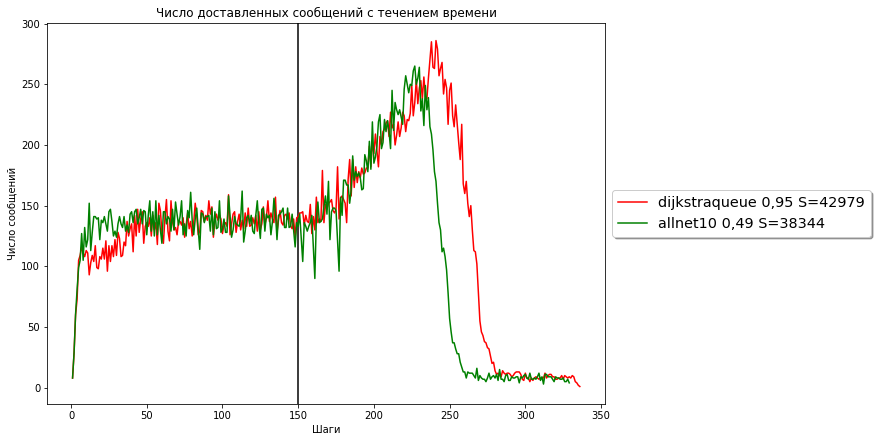

Доставлено 80396 Потеряно 23.4331% -dijkstraqueue 0,95
Доставлено 43260 Потеряно 58.8004% -allnet10 0,49


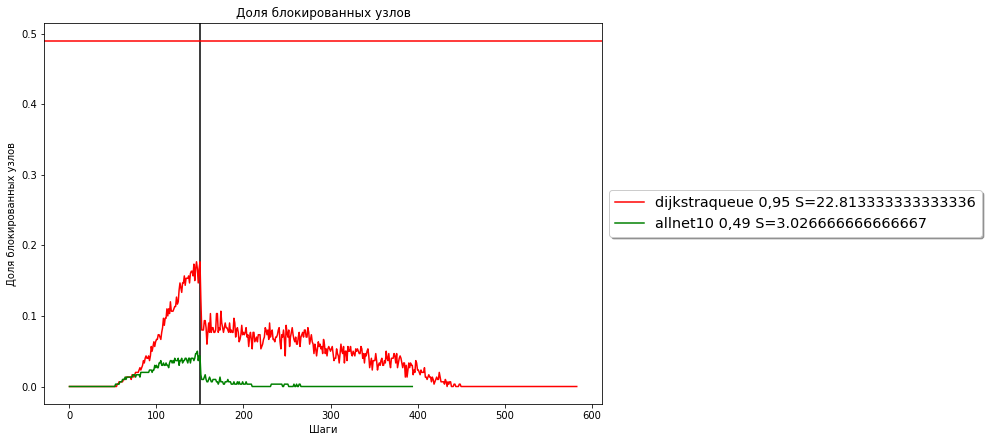

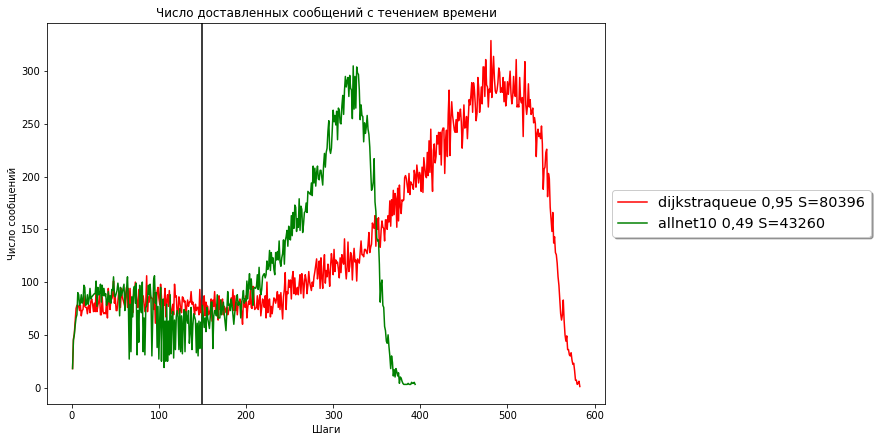

Доставлено 85122 Потеряно 36.9471% -dijkstraqueue 0,95
Доставлено 41305 Потеряно 69.4039% -allnet10 0,49


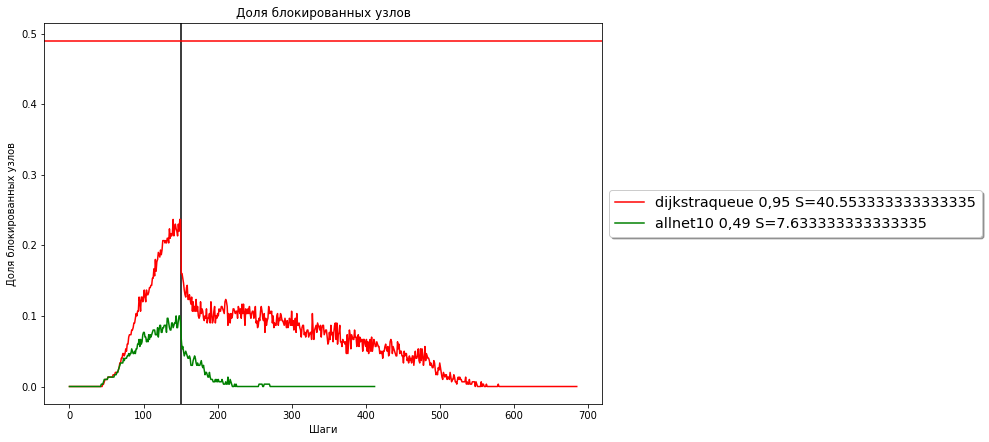

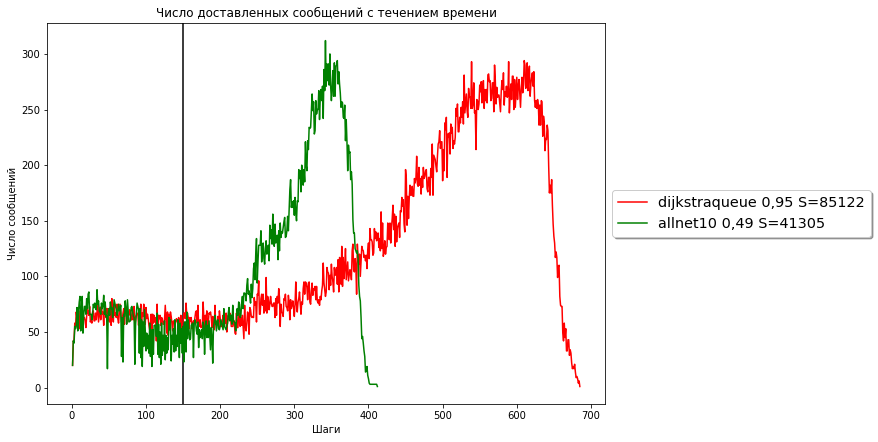

Доставлено 84098 Потеряно 56.8730% -dijkstraqueue 0,95
Доставлено 38875 Потеряно 80.0642% -allnet10 0,49


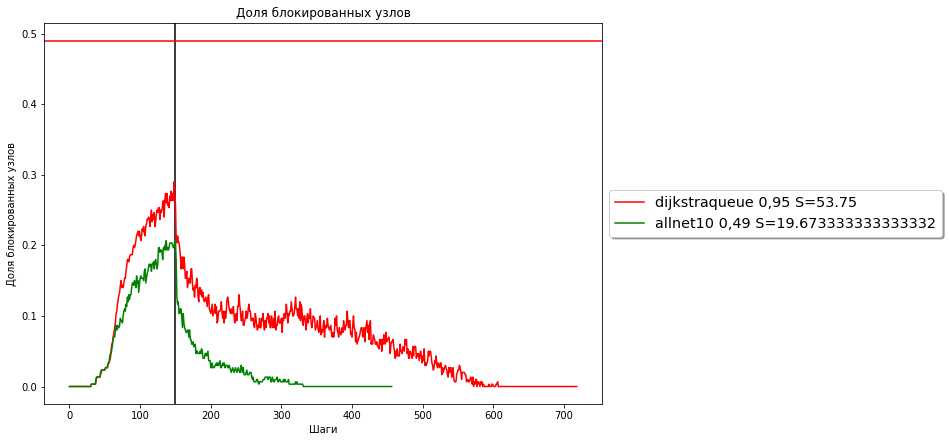

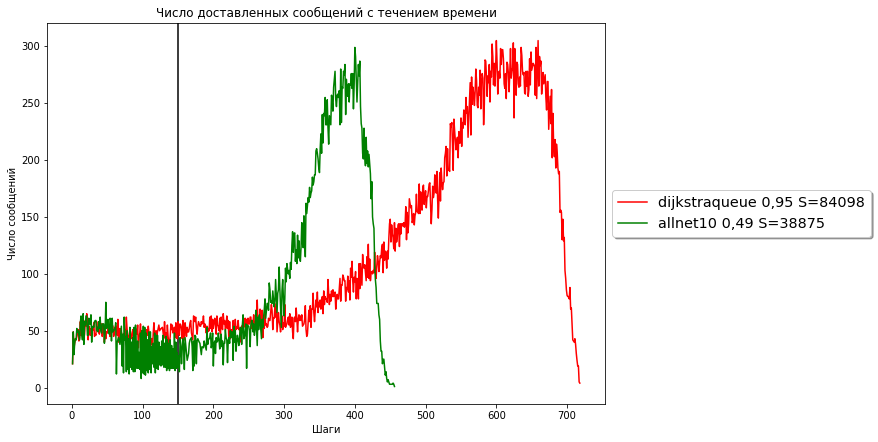

In [6]:
quantity = 300;
log_tags = [
{"tag":  "2b1c7fb0-3364-4c63-b503-6173fb73f071", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "1bcd03ff-11ce-4a2b-b501-703c32e17432", "label": "allnet10 0,49", "color": "green"},
]
showStatBlocked();
showStatMessage();

quantity = 700;
log_tags = [
{"tag":  "e04aad34-ef10-4367-9496-9aa238ca1543", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "7bb79ed1-cf13-4837-8571-a058bacba202", "label": "allnet10 0,49", "color": "green"},
]
showStatBlocked();
showStatMessage();

quantity = 900;
log_tags = [
{"tag":  "8fae47a9-f858-4999-a322-a5e3c70d505c", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "15e5c7ef-0d1f-4001-93be-c89ecd5345fb", "label": "allnet10 0,49", "color": "green"},
]
showStatBlocked();
showStatMessage();

quantity = 1300;
log_tags = [
{"tag":  "d78b08f4-131d-49e8-9059-b5a9be0017a7", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "0e6a8019-439d-40de-82f3-8af4fff022b3", "label": "allnet10 0,49", "color": "green"},
]
showStatBlocked();
showStatMessage();

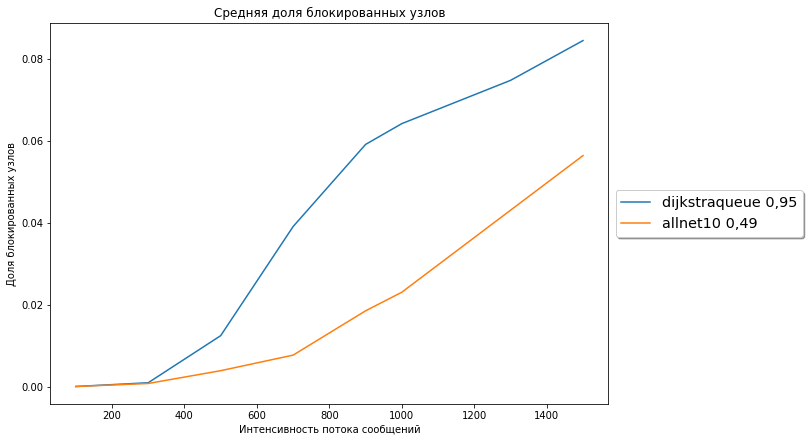

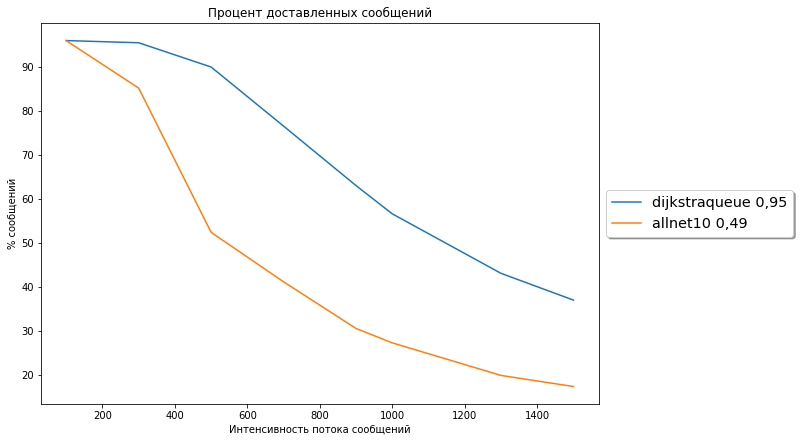

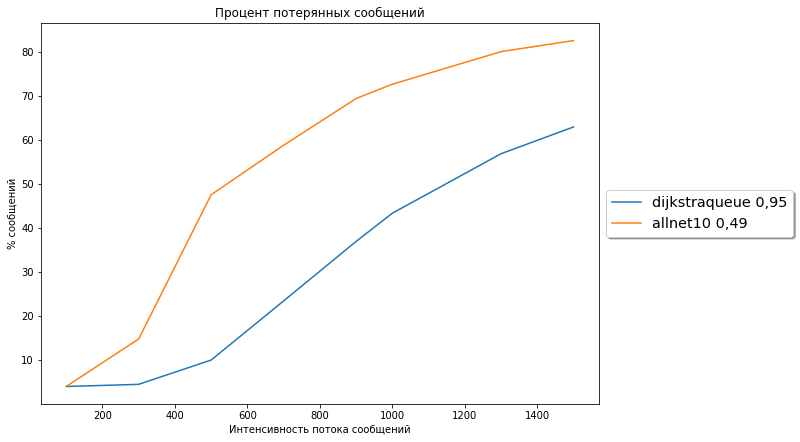

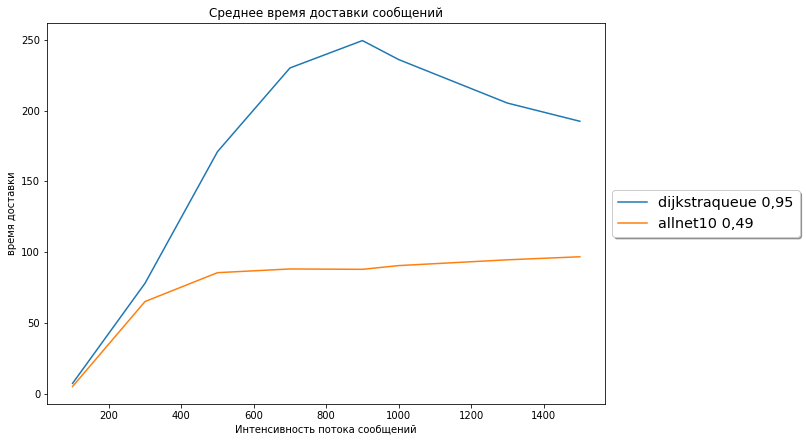

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

dijkstraqueue 0,95    0.041867
allnet10 0,49         0.019151

dijkstraqueue 0,95    30.258499
allnet10 0,49         53.733722

dijkstraqueue 0,95    171.270438
allnet10 0,49          76.746389
